# **Importing Modules**

In [ ]:
! pip install -q pymoo

In [ ]:
# import torch
import time
import numpy as np
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.termination import get_termination
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# **Lake problem**

In [ ]:
class LakeProblem(ElementwiseProblem):

    def __init__(self, n_years=100, delta=0.98, X_crit=0.54):
        super().__init__(n_var=n_years, n_obj=3, n_constr=0, xl=0.0, xu=1)
        self.n_years = n_years
        self.b = 0.42
        self.q = 2.00
        self.alpha_o = 0.4
        self.beta_1 = 0.08
        self.delta = delta
        self.X_crit = X_crit  # Critical threshold for reliability

    def _evaluate(self, a, out, *args, **kwargs):
        # a: Anthropogenic pollution over time

        # Initialize the phosphorus concentration
        X = np.zeros(self.n_years)
        X[0] = 0.01  # Initial phosphorus concentration

        # Simulate phosphorus dynamics over time
        for t in range(self.n_years - 1):
            X[t+1] = X[t] - self.b * X[t] + (X[t]**self.q) / (1 + X[t]**self.q) + a[t]

        # Objective 1: Minimize mean phosphorus concentration (FE)
        mean_phosphorus_concentration = np.mean(X)

        # Objective 2: Maximize the net present value of utility (FV), but we minimize -FV for consistency
        utility = np.zeros(self.n_years)
        for t in range(self.n_years):
            utility[t] = self.alpha_o * a[t] - self.beta_1 * X[t]**2

        # Net present value of utility with discount factor
        net_present_value_utility = np.sum([self.delta**t * utility[t] for t in range(self.n_years)])

        # Objective 3: Maximize reliability (FR)
        theta = np.zeros(self.n_years)
        for t in range(self.n_years):
            theta[t] = 1 if X[t] < self.X_crit else 0
        reliability = np.mean(theta)  # Proportion of years where X[t] < X_crit

        # Set objectives: minimize phosphorus concentration, maximize utility, maximize reliability
        out["F"] = [-net_present_value_utility, mean_phosphorus_concentration, -reliability]


In [ ]:
# Define the optimization problem
n_years = 100  # Number of years to simulate
problem = LakeProblem(n_years=n_years)

In [ ]:
# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=100)

# **NSGA2 200 gen**

In [ ]:
# NSGA-II Algorithm
algorithm = NSGA2(pop_size=100)

# Termination criterion (we stop after a certain number of generations)
termination = get_termination("n_gen", 200)

start_time = time.time()

# Solve the problem
res_NSGA2_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
# # Plot the Pareto front
# Scatter().add(res_NSGA2.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      4 |  0.1124835707 |         ideal
     3 |      300 |      7 |  0.0471732532 |         ideal
     4 |      400 |      3 |  0.5660815967 |         ideal
     5 |      500 |      2 |  1.9602487793 |         ideal
     6 |      600 |      1 |  1.5227212508 |         ideal
     7 |      700 |      2 |  1.0000000000 |         ideal
     8 |      800 |      3 |  1.0000000000 |         ideal
     9 |      900 |      2 |  1.0000000000 |         ideal
    10 |     1000 |      3 |  0.8013984934 |         ideal
    11 |     1100 |      5 |  0.2228893935 |         ideal
    12 |     1200 |      6 |  0.7410939806 |         ideal
    13 |     1300 |      5 |  0.2427476895 |         ideal
    14 |     1400 |      4 |  0.5420163461 |         ideal
    15 |     1500 |      4 |  1.2415556096 |         nadir
    16 |     1600 |      3 |  0.4000000000 |         ide

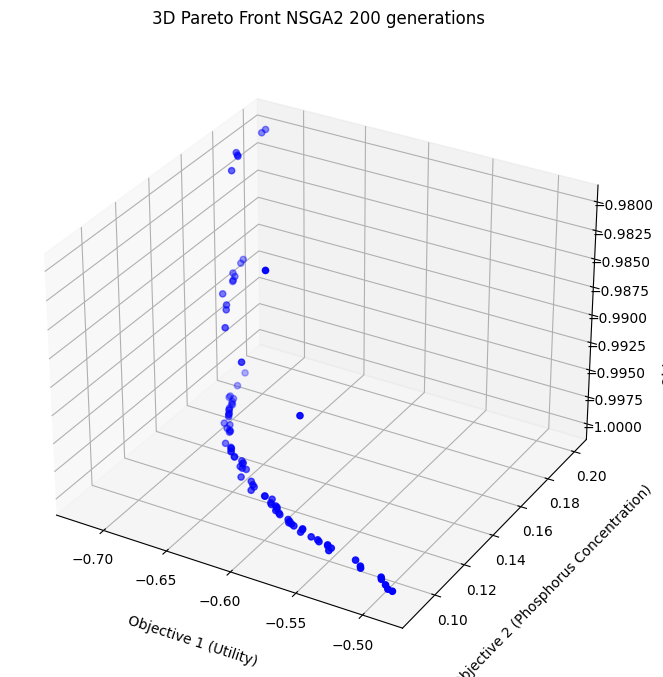

In [ ]:
pareto_front = res_NSGA2_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front NSGA2 200 generations', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


# **NSGA2 500 gen**

In [ ]:
# NSGA-II Algorithm
algorithm = NSGA2(pop_size=100)

# Termination criterion (we stop after a certain number of generations)
termination = get_termination("n_gen", 500)

start_time = time.time()

# Solve the problem
res_NSGA2_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_NSGA2.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      4 |  0.1124835707 |         ideal
     3 |      300 |      7 |  0.0471732532 |         ideal
     4 |      400 |      3 |  0.5660815967 |         ideal
     5 |      500 |      2 |  1.9602487793 |         ideal
     6 |      600 |      1 |  1.5227212508 |         ideal
     7 |      700 |      2 |  1.0000000000 |         ideal
     8 |      800 |      3 |  1.0000000000 |         ideal
     9 |      900 |      2 |  1.0000000000 |         ideal
    10 |     1000 |      3 |  0.8013984934 |         ideal
    11 |     1100 |      5 |  0.2228893935 |         ideal
    12 |     1200 |      6 |  0.7410939806 |         ideal
    13 |     1300 |      5 |  0.2427476895 |         ideal
    14 |     1400 |      4 |  0.5420163461 |         ideal
    15 |     1500 |      4 |  1.2415556096 |         nadir
    16 |     1600 |      3 |  0.4000000000 |         ide

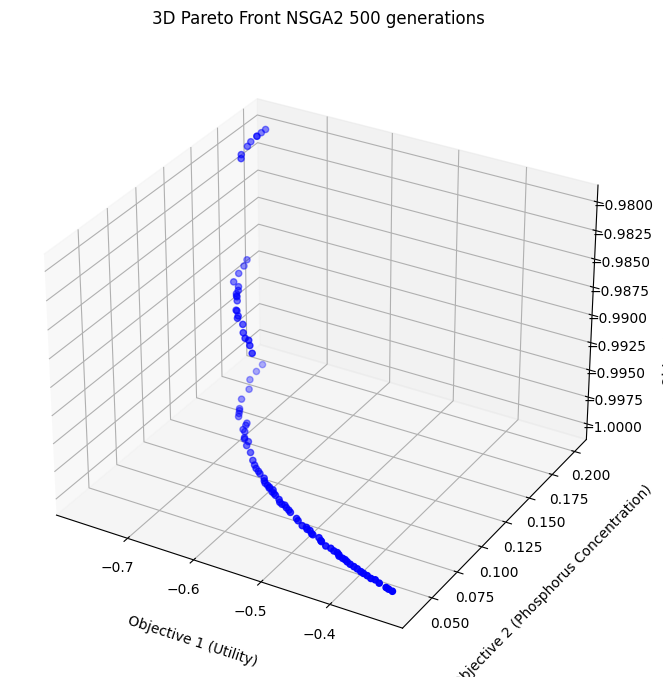

In [ ]:
pareto_front = res_NSGA2_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front NSGA2 500 generations', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


# **NSGA2 1000 gen**

In [ ]:
# NSGA-II Algorithm
algorithm = NSGA2(pop_size=100)

# Termination criterion (we stop after a certain number of generations)
termination = get_termination("n_gen", 1000)

# Start the timer
start_time = time.time()
# Solve the problem
res_NSGA2_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Stop the timer
end_time = time.time()
# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
# # Plot the Pareto front
# Scatter().add(res_NSGA2.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      4 |  0.1124835707 |         ideal
     3 |      300 |      7 |  0.0471732532 |         ideal
     4 |      400 |      3 |  0.5660815967 |         ideal
     5 |      500 |      2 |  1.9602487793 |         ideal
     6 |      600 |      1 |  1.5227212508 |         ideal
     7 |      700 |      2 |  1.0000000000 |         ideal
     8 |      800 |      3 |  1.0000000000 |         ideal
     9 |      900 |      2 |  1.0000000000 |         ideal
    10 |     1000 |      3 |  0.8013984934 |         ideal
    11 |     1100 |      5 |  0.2228893935 |         ideal
    12 |     1200 |      6 |  0.7410939806 |         ideal
    13 |     1300 |      5 |  0.2427476895 |         ideal
    14 |     1400 |      4 |  0.5420163461 |         ideal
    15 |     1500 |      4 |  1.2415556096 |         nadir
    16 |     1600 |      3 |  0.4000000000 |         ide

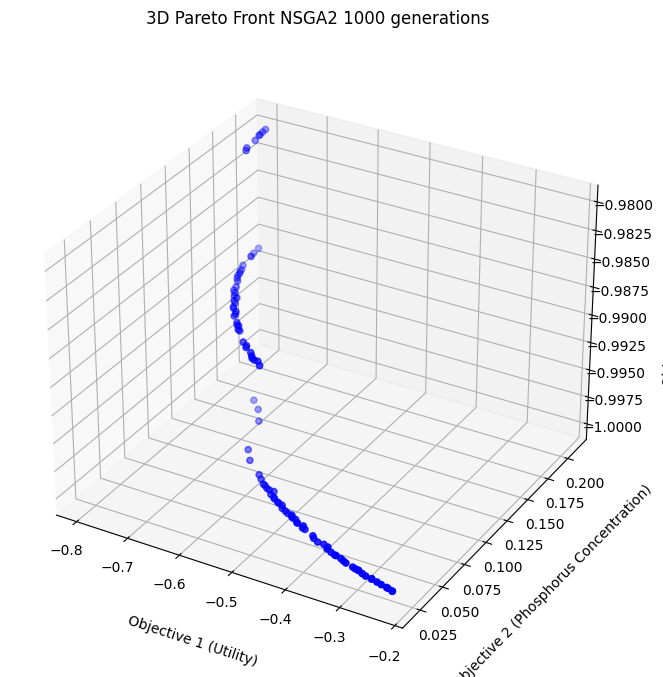

In [ ]:
pareto_front = res_NSGA2_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front NSGA2 1000 generations', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


In [ ]:
# Assuming res_MOEAD.F has three objectives
df = pd.DataFrame(res_NSGA2_3.F, columns=['Objective 1', 'Objective 2', 'Objective 3'])
df.to_csv('results_NSGA2_3.csv', index=False)

# Saving decision variables
df_decisions = pd.DataFrame(res_NSGA2_3.X, columns=[f'Decision Variable {i+1}' for i in range(res_NSGA2_3.X.shape[1])])
df_decisions.to_csv('decision_variables_NSGA2_3.csv', index=False)

# **MOEA/D 200 gen**

In [ ]:
# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=25,  # Number of neighboring subproblems
    prob_neighbor_mating=0.5,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 200)

# Start the timer
start_time = time.time()
# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |     22 |  0.4405730846 |         ideal
     3 |      273 |     19 |  0.4246770148 |         ideal
     4 |      364 |     13 |  8.061051E+01 |         ideal
     5 |      455 |     14 |  0.4474415665 |         ideal
     6 |      546 |     27 |  0.1835541093 |         ideal
     7 |      637 |     19 |  1.943550E+01 |         ideal
     8 |      728 |     14 |  0.3991808667 |         ideal
     9 |      819 |     17 |  0.0864355619 |         ideal
    10 |      910 |     11 |  0.5686089774 |         ideal
    11 |     1001 |     19 |  0.3223947710 |         ideal
    12 |     1092 |     19 |  1.858224E+01 |         ideal
    13 |     1183 |     43 |  1.0200370821 |         ideal
    14 |     1274 |     19 |  0.4180231020 |         ideal
    15 |     1365 |     25 |  0.2952682476 |         ideal
    16 |     1456 |     25 |  0.6638019990 |         ide

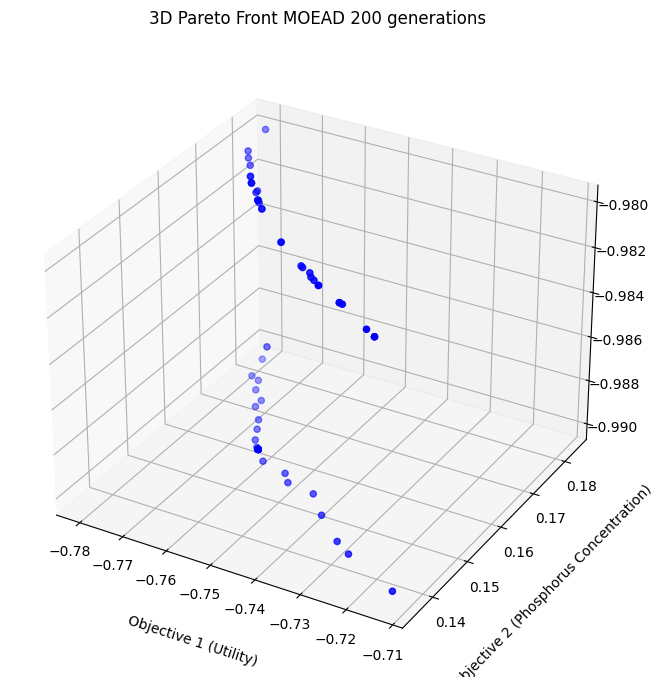

In [ ]:
pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 200 generations', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


# **MOEA/D 500 gen**

In [ ]:
# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=25,  # Number of neighboring subproblems
    prob_neighbor_mating=0.5,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 500)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |     22 |  0.4405730846 |         ideal
     3 |      273 |     19 |  0.4246770148 |         ideal
     4 |      364 |     13 |  8.061051E+01 |         ideal
     5 |      455 |     14 |  0.4474415665 |         ideal
     6 |      546 |     27 |  0.1835541093 |         ideal
     7 |      637 |     19 |  1.943550E+01 |         ideal
     8 |      728 |     14 |  0.3991808667 |         ideal
     9 |      819 |     17 |  0.0864355619 |         ideal
    10 |      910 |     11 |  0.5686089774 |         ideal
    11 |     1001 |     19 |  0.3223947710 |         ideal
    12 |     1092 |     19 |  1.858224E+01 |         ideal
    13 |     1183 |     43 |  1.0200370821 |         ideal
    14 |     1274 |     19 |  0.4180231020 |         ideal
    15 |     1365 |     25 |  0.2952682476 |         ideal
    16 |     1456 |     25 |  0.6638019990 |         ide

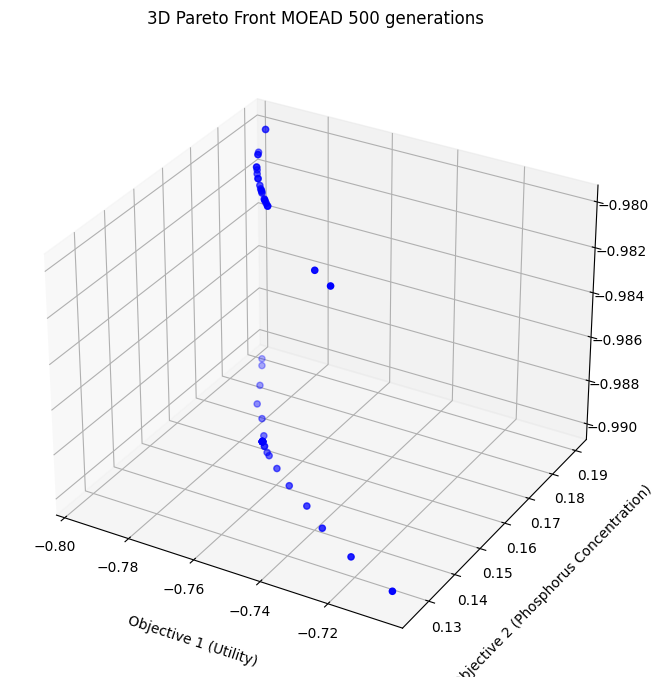

In [ ]:
pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 500 generations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


# **MOEA/D 1000 gen**

In [ ]:
# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=25,  # Number of neighboring subproblems
    prob_neighbor_mating=0.5,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 1000)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |     22 |  0.4405730846 |         ideal
     3 |      273 |     19 |  0.4246770148 |         ideal
     4 |      364 |     13 |  8.061051E+01 |         ideal
     5 |      455 |     14 |  0.4474415665 |         ideal
     6 |      546 |     27 |  0.1835541093 |         ideal
     7 |      637 |     19 |  1.943550E+01 |         ideal
     8 |      728 |     14 |  0.3991808667 |         ideal
     9 |      819 |     17 |  0.0864355619 |         ideal
    10 |      910 |     11 |  0.5686089774 |         ideal
    11 |     1001 |     19 |  0.3223947710 |         ideal
    12 |     1092 |     19 |  1.858224E+01 |         ideal
    13 |     1183 |     43 |  1.0200370821 |         ideal
    14 |     1274 |     19 |  0.4180231020 |         ideal
    15 |     1365 |     25 |  0.2952682476 |         ideal
    16 |     1456 |     25 |  0.6638019990 |         ide

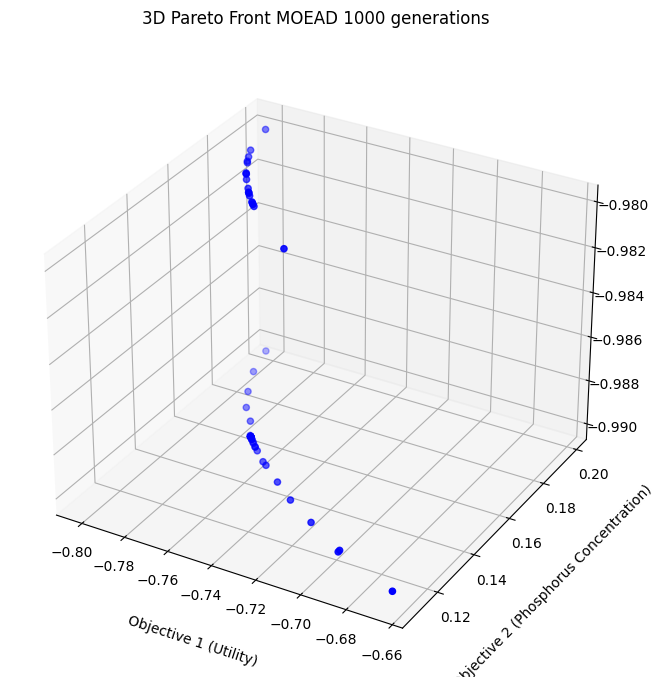

In [ ]:
pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 1000 generations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


In [ ]:
# Assuming res_MOEAD.F has three objectives
df = pd.DataFrame(res_MOEAD_3.F, columns=['Objective 1', 'Objective 2', 'Objective 3'])
df.to_csv('results_MOEAD_3.csv', index=False)

# Saving decision variables
df_decisions = pd.DataFrame(res_MOEAD_3.X, columns=[f'Decision Variable {i+1}' for i in range(res_MOEAD_3.X.shape[1])])
df_decisions.to_csv('decision_variables_MOEAD_3.csv', index=False)

# **Plotting 1000 gen for both algorithms**

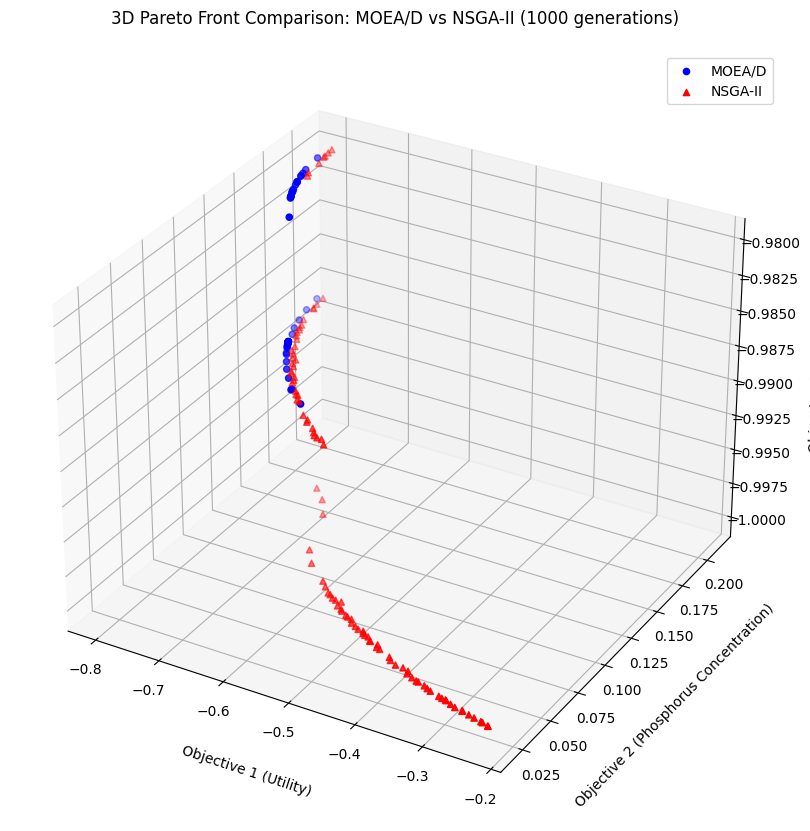

In [ ]:
# Extract the three objectives from MOEA/D results
pareto_front_moead = res_MOEAD_3.F
obj1_moead = pareto_front_moead[:, 0]
obj2_moead = pareto_front_moead[:, 1]
obj3_moead = pareto_front_moead[:, 2]

# Extract the three objectives from NSGA-II results
pareto_front_nsga2 = res_NSGA2_3.F
obj1_nsga2 = pareto_front_nsga2[:, 0]
obj2_nsga2 = pareto_front_nsga2[:, 1]
obj3_nsga2 = pareto_front_nsga2[:, 2]

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front for MOEA/D
scatter_moead = ax.scatter(obj1_moead, obj2_moead, obj3_moead, c='blue', marker='o', label='MOEA/D')

# Plot the Pareto front for NSGA-II
scatter_nsga2 = ax.scatter(obj1_nsga2, obj2_nsga2, obj3_nsga2, c='red', marker='^', label='NSGA-II')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)

# Add title
ax.set_title('3D Pareto Front Comparison: MOEA/D vs NSGA-II (1000 generations)', pad=20)

# Add a legend to differentiate the two algorithms
ax.legend()

# Show the plot
plt.show()

In [ ]:
import plotly.graph_objs as go
import numpy as np

# Sample data (replace this with your actual data extraction)
# Extract the three objectives from MOEA/D results
pareto_front_moead = res_MOEAD_3.F
obj1_moead = pareto_front_moead[:, 0]
obj2_moead = pareto_front_moead[:, 1]
obj3_moead = pareto_front_moead[:, 2]

# Extract the three objectives from NSGA-II results
pareto_front_nsga2 = res_NSGA2_3.F
obj1_nsga2 = pareto_front_nsga2[:, 0]
obj2_nsga2 = pareto_front_nsga2[:, 1]
obj3_nsga2 = pareto_front_nsga2[:, 2]

# Create the 3D scatter plot for MOEA/D
scatter_moead = go.Scatter3d(
    x=obj1_moead,
    y=obj2_moead,
    z=obj3_moead,
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='MOEA/D'
)

# Create the 3D scatter plot for NSGA-II
scatter_nsga2 = go.Scatter3d(
    x=obj1_nsga2,
    y=obj2_nsga2,
    z=obj3_nsga2,
    mode='markers',
    marker=dict(size=5, color='red'),
    name='NSGA-II'
)

# Layout for the plot
layout = go.Layout(
    title='3D Pareto Front Comparison: MOEA/D vs NSGA-II (1000 generations)',
    scene=dict(
        xaxis_title='Objective 1 (Utility)',
        yaxis_title='Objective 2 (Phosphorus Concentration)',
        zaxis_title='Objective 3 (Reliability)'
    ),
    legend=dict(x=0, y=1)
)

# Combine the plots
fig = go.Figure(data=[scatter_moead, scatter_nsga2], layout=layout)

# Show the interactive plot
fig.show()


# **Trials**

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |     25 |  0.5500845566 |         ideal
     3 |      273 |     49 |  1.163322E+01 |         ideal
     4 |      364 |     15 |  0.2337096607 |         ideal
     5 |      455 |     10 |  0.2235088219 |         ideal
     6 |      546 |     35 |  0.3864733744 |         ideal
     7 |      637 |     25 |  0.2335361734 |         ideal
     8 |      728 |      6 |  0.4400215719 |         ideal
     9 |      819 |      7 |  0.1265225037 |         ideal
    10 |      910 |     19 |  0.2746734859 |         ideal
    11 |     1001 |     25 |  2.641484E+02 |         ideal
    12 |     1092 |     19 |  1.099649E+03 |         ideal
    13 |     1183 |     25 |  0.5102766012 |         ideal
    14 |     1274 |     10 |  0.4419213418 |         ideal
    15 |     1365 |     30 |  0.4261345379 |         ideal
    16 |     1456 |     25 |  0.2432229797 |         ide

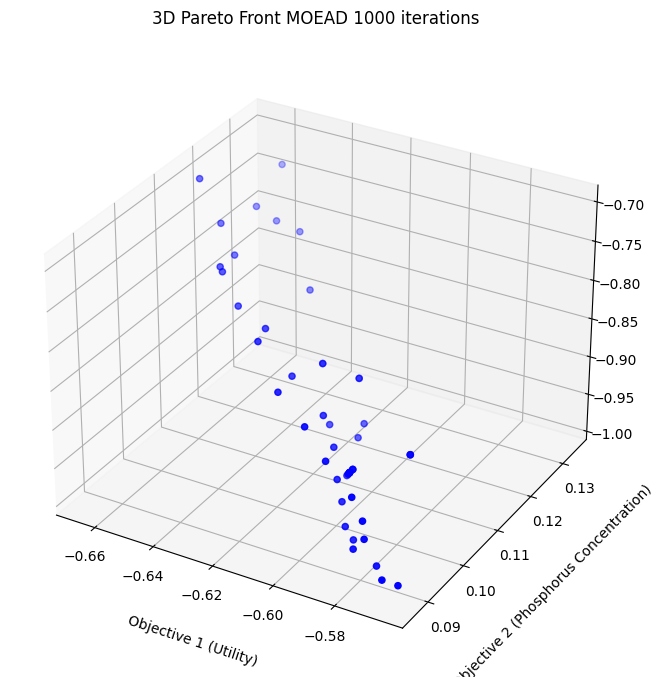

In [ ]:
# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=25,  # Number of neighboring subproblems
    prob_neighbor_mating=0.5,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 1000)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 1000 iterations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |     18 |  0.1486850747 |         ideal
     3 |      273 |     43 |  2.274408E+01 |         ideal
     4 |      364 |     18 |  1.064889E+02 |         ideal
     5 |      455 |     24 |  0.2438766169 |         ideal
     6 |      546 |     30 |  0.4868000503 |         ideal
     7 |      637 |     30 |  0.3699363064 |         ideal
     8 |      728 |     16 |  0.4516621945 |         ideal
     9 |      819 |     12 |  0.2545703749 |         ideal
    10 |      910 |     44 |  0.3834770078 |         ideal
    11 |     1001 |     30 |  0.2850113552 |         ideal
    12 |     1092 |     30 |  0.1577107108 |         ideal
    13 |     1183 |     12 |  0.1443414595 |         ideal
    14 |     1274 |     48 |  0.4516993334 |         ideal
    15 |     1365 |     41 |  9.895705E+01 |         ideal
    16 |     1456 |     17 |  0.1680646231 |         ide

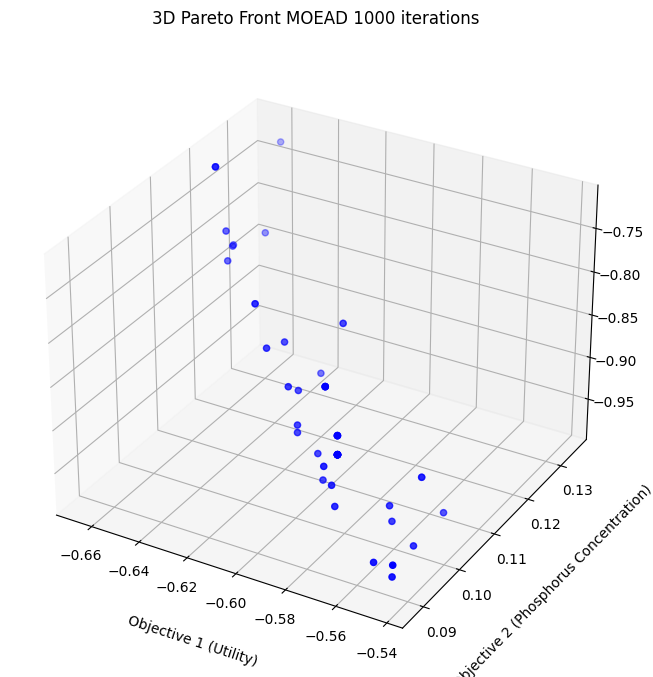

In [ ]:

# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=30,  # Number of neighboring subproblems
    prob_neighbor_mating=0.5,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 500)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 1000 iterations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |      8 |  1.2141780845 |         ideal
     3 |      273 |     13 |  0.3555014843 |         ideal
     4 |      364 |     43 |  3.077990E+01 |         ideal
     5 |      455 |     26 |  0.3529127992 |         ideal
     6 |      546 |     30 |  0.4338359506 |         ideal
     7 |      637 |     40 |  0.2706702103 |         ideal
     8 |      728 |     13 |  0.3297471977 |         ideal
     9 |      819 |      5 |  0.3311004872 |         ideal
    10 |      910 |     27 |  2.136521E+02 |         ideal
    11 |     1001 |     30 |  0.6314984917 |         ideal
    12 |     1092 |     33 |  1.071498E+02 |         ideal
    13 |     1183 |     30 |  0.4510326959 |         ideal
    14 |     1274 |     67 |  5.706848E+01 |         ideal
    15 |     1365 |     58 |  0.1455460962 |         ideal
    16 |     1456 |     61 |  1.876400E+03 |         ide

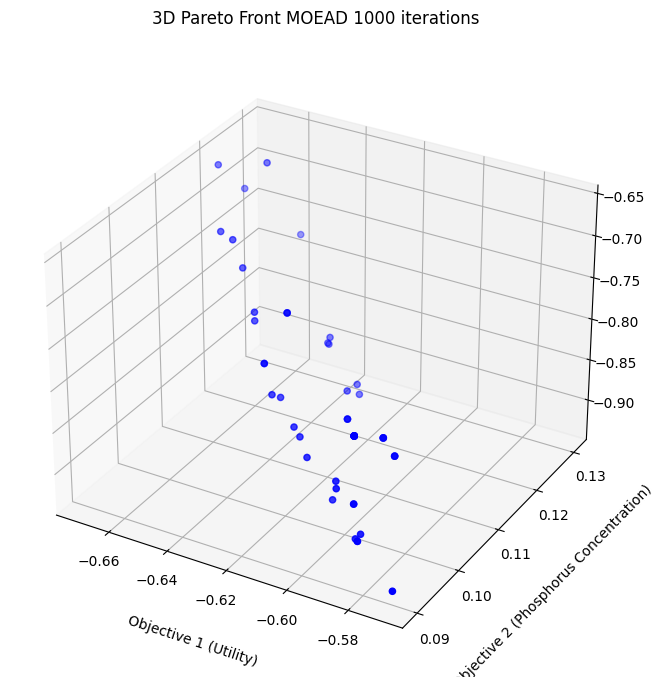

In [ ]:

# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=30,  # Number of neighboring subproblems
    prob_neighbor_mating=0.4,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 500)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 1000 iterations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |     56 |  0.4262488093 |         ideal
     3 |      273 |     76 |  2.210359E+01 |         ideal
     4 |      364 |     35 |  0.3905955964 |         ideal
     5 |      455 |     35 |  0.5501972085 |         ideal
     6 |      546 |     35 |  0.2842089329 |         ideal
     7 |      637 |     58 |  5.871046E+01 |         ideal
     8 |      728 |     35 |  0.1613078669 |         ideal
     9 |      819 |     35 |  0.3979525065 |         ideal
    10 |      910 |     53 |  0.2891317683 |         ideal
    11 |     1001 |     66 |  0.2492453907 |         ideal
    12 |     1092 |     36 |  3.147317E+01 |         ideal
    13 |     1183 |     51 |  0.2257477038 |         ideal
    14 |     1274 |     35 |  0.3585768458 |         ideal
    15 |     1365 |     35 |  0.4856404105 |         ideal
    16 |     1456 |     35 |  0.3296832961 |         ide

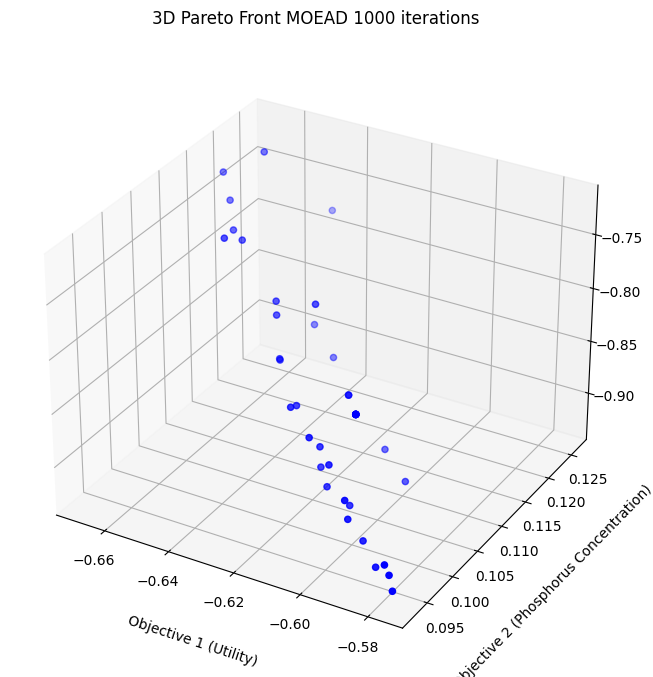

In [ ]:

# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=35,  # Number of neighboring subproblems
    prob_neighbor_mating=0.4,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 500)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 1000 iterations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       91 |      2 |             - |             -
     2 |      182 |      1 |  0.0100000000 |         ideal
     3 |      273 |     38 |  0.2880910568 |         ideal
     4 |      364 |     42 |  4.386430E+02 |         ideal
     5 |      455 |     35 |  0.6355386597 |         ideal
     6 |      546 |     40 |  9.002821E+02 |         ideal
     7 |      637 |     41 |  5.106577E+02 |         ideal
     8 |      728 |     41 |  0.3517464551 |         ideal
     9 |      819 |     44 |  0.3233299567 |         ideal
    10 |      910 |     35 |  1.510420E+02 |         ideal
    11 |     1001 |      8 |  0.4977601299 |         ideal
    12 |     1092 |     23 |  0.3883968533 |         ideal
    13 |     1183 |     49 |  1.762196E+02 |         ideal
    14 |     1274 |     64 |  1.294994E+02 |         ideal
    15 |     1365 |     50 |  0.2984463757 |         ideal
    16 |     1456 |     40 |  0.3216448920 |         ide

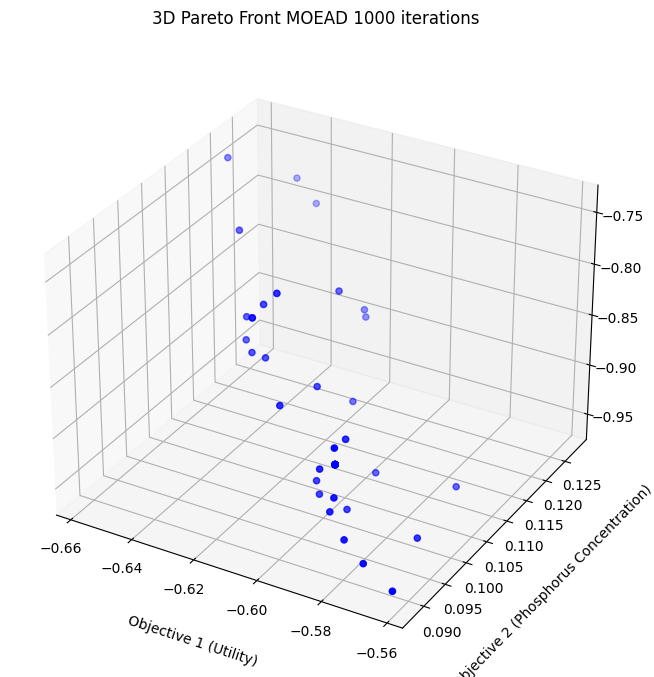

In [ ]:

# Reference directions for decomposition (weights for the subproblems)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# MOEA/D Algorithm
algorithm = MOEAD(
    ref_dirs=ref_dirs,
    n_neighbors=40,  # Number of neighboring subproblems
    prob_neighbor_mating=0.5,  # Probability of mating within neighbors
)

# Termination criterio  n (number of generations)
termination = get_termination("n_gen", 500)

# Start the timer
start_time = time.time()

# Solve the problem
res_MOEAD_3 = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# # Plot the Pareto front
# Scatter().add(res_MOEAD.F).show()

pareto_front = res_MOEAD_3.F
# Extract the three objectives for the plot
obj1 = pareto_front[:, 0]  # First objective (Net Present Value of Utility)
obj2 = pareto_front[:, 1]  # Second objective (Mean Phosphorus Concentration)
obj3 = pareto_front[:, 2]  # Third objective (Reliability)

# Create a 3D scatter plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot the Pareto front in 3D space
scatter = ax.scatter(obj1, obj2, obj3, c='blue', marker='o')

# Label the axes
ax.set_xlabel('Objective 1 (Utility)', labelpad=15)  # Increase padding
ax.set_ylabel('Objective 2 (Phosphorus Concentration)', labelpad=15)  # Increase padding
ax.set_zlabel('Objective 3 (Reliability)', labelpad=15)  # Increase padding

# Add title
ax.set_title('3D Pareto Front MOEAD 1000 iterations ', pad=20)  # Increase padding for the title

# Show the plot
plt.show()
